This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff), Chapter 12.

This notebook was generated for TensorFlow 2.6.

## Introduction to generative adversarial networks
Generative adversarial networks (GANs), introduced in 2014 by Goodfellow et al.,7 are
an alternative to VAEs for learning latent spaces of images. They enable the generation
of fairly realistic synthetic images by forcing the generated images to be statistically
almost indistinguishable from real ones.
An intuitive way to understand GANs is to imagine a forger trying to create a fake
Picasso painting. At first, the forger is pretty bad at the task. He mixes some of his
fakes with authentic Picassos and shows them all to an art dealer. The art dealer makes
an authenticity assessment for each painting and gives the forger feedback about what
makes a Picasso look like a Picasso. The forger goes back to his studio to prepare some
new fakes. As time goes on, the forger becomes increasingly competent at imitating
the style of Picasso, and the art dealer becomes increasingly expert at spotting fakes.
In the end, they have on their hands some excellent fake Picassos.
That’s what a GAN is: a forger network and an expert network, each being trained
to best the other. As such, a GAN is made of two parts:
<ul>
    <li>Generator network—Takes as input a random vector (a random point in the
latent space), and decodes it into a synthetic image
<li>Discriminator network (or adversary)—Takes as input an image (real or synthetic),
and predicts whether the image came from the training set or was created by
the generator network
</ul>

7 Ian Goodfellow et al., “Generative Adversarial Networks,” arXiv (2014), https://arxiv.org/abs/1406.2661.

The generator network is trained to be able to fool the discriminator network, and
thus it evolves toward generating increasingly realistic images as training goes on: artificial
images that look indistinguishable from real ones, to the extent that it’s impossible
for the discriminator network to tell the two apart (see figure 12.19). Meanwhile,
the discriminator is constantly adapting to the gradually improving capabilities of the
generator, setting a high bar of realism for the generated images. Once training is
over, the generator is capable of turning any point in its input space into a believable
image. **Unlike VAEs, this latent space has fewer explicit guarantees of meaningful
structure; in particular, it isn’t continuous.**

**Figure 12.19** A generator transforms random latent vectors into images, and a discriminator
seeks to tell real images from generated ones. The generator is trained to fool the discriminator

Remarkably, a GAN is a system where the optimization minimum isn’t fixed, unlike in
any other training setup you’ve encountered in this book. Normally, gradient descent
consists of rolling down hills in a static loss landscape. But with a GAN, every step
taken down the hill changes the entire landscape a little. It’s a dynamic system where
the optimization process is seeking not a minimum, but an equilibrium between two
forces. For this reason, GANs are notoriously difficult to train—getting a GAN to work
requires lots of careful tuning of the model architecture and training parameters.

### A schematic GAN implementation

In this section, we’ll explain how to implement a GAN in Keras in its barest form.
GANs are advanced, so diving deeply into the technical details of architectures like
that of the StyleGAN2 that generated the images in figure 12.20 would be out of scope
for this book. The specific implementation we’ll use in this demonstration is a deep
convolutional GAN (DCGAN): a very basic GAN where the generator and discriminator
are deep convnets.

**Figure 12.20** Latent space dwellers. Images generated by https://thispersondoesnotexist.com
using a StyleGAN2 model. (Image credit: Phillip Wang is the website author. The model used is the
StyleGAN2 model from Karras et al., https://arxiv.org/abs/1912.04958.)

We’ll train our GAN on images from the Large-scale CelebFaces Attributes dataset
(known as CelebA), a dataset of 200,000 faces of celebrities (http://mmlab.ie.cuhk
.edu.hk/projects/CelebA.html) To speed up training, we’ll resize the images to 64 × 64,
so we’ll be learning to generate 64 × 64 images of human faces.
Schematically, the GAN looks like this:
<ul>
    <li>A generator network maps vectors of shape (latent_dim,) to images of shape
(64, 64, 3).
<li>A discriminator network maps images of shape (64, 64, 3) to a binary score
estimating the probability that the image is real.
<li>A gan network chains the generator and the discriminator together: gan(x) =
discriminator(generator(x)). Thus, this gan network maps latent space vectors
to the discriminator’s assessment of the realism of these latent vectors as
decoded by the generator.
<li>We train the discriminator using examples of real and fake images along with
“real”/“fake” labels, just as we train any regular image-classification model.
<li>To train the generator, we use the gradients of the generator’s weights with
regard to the loss of the gan model. This means that at every step, we move the
weights of the generator in a direction that makes the discriminator more likely
to classify as “real” the images decoded by the generator. In other words, we
train the generator to fool the discriminator.
    </ul>

### A bag of tricks
The process of training GANs and tuning GAN implementations is notoriously difficult.
There are a number of known tricks you should keep in mind. Like most things
in deep learning, it’s more alchemy than science: these tricks are heuristics, not theory backed
guidelines. They’re supported by a level of intuitive understanding of the phenomenon
at hand, and they’re known to work well empirically, although not necessarily
in every context.

Here are a few of the tricks used in the implementation of the GAN generator and
discriminator in this section. It isn’t an exhaustive list of GAN-related tips; you’ll find
many more across the GAN literature:
<ul>
    <li>We use strides instead of pooling for downsampling feature maps in the discriminator,
just like we did in our VAE encoder.
<li>We sample points from the latent space using a normal distribution (Gaussian distribution),
not a uniform distribution.
<li>Stochasticity is good for inducing robustness. Because GAN training results in a
dynamic equilibrium, GANs are likely to get stuck in all sorts of ways. Introducing
randomness during training helps prevent this. We introduce randomness
by adding random noise to the labels for the discriminator.
<li>Sparse gradients can hinder GAN training. In deep learning, sparsity is often
a desirable property, but not in GANs. Two things can induce gradient sparsity:
max pooling operations and relu activations. Instead of max pooling,
we recommend using strided convolutions for downsampling, and we recommend
using a LeakyReLU layer instead of a relu activation. It’s similar to
relu, but it relaxes sparsity constraints by allowing small negative activation
values.
<li>In generated images, it’s common to see checkerboard artifacts caused by
unequal coverage of the pixel space in the generator (see figure 12.21). To fix
this, we use a kernel size that’s divisible by the stride size whenever we use a
strided `Conv2DTranspose` or `Conv2D` in both the generator and the discriminator.
   </ul>

**Figure 12.21** Checkerboard artifacts caused by mismatching strides and kernel
sizes, resulting in unequal pixel-space coverage: one of the many gotchas of GANs

### Getting our hands on the CelebA dataset
You can download the dataset manually from the website: http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html.

If you’re using Colab, you can run the following to download
the data from Google Drive and uncompress it.

**Getting the CelebA data**

In [1]:
# Create a working directory.
!mkdir celeba_gan
# Download the compressed data using gdown
# (available by default in Colab; install it otherwise)
!gdown --id 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celeba_gan/data.zip
# Uncompress the data
!unzip -qq celeba_gan/data.zip -d celeba_gan

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684
From (redirected): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684&confirm=t&uuid=86a7b6e9-4534-4e47-abad-766f17bd6edd
To: /content/celeba_gan/data.zip
100% 1.44G/1.44G [00:26<00:00, 55.3MB/s]


#### On Windows I went to:
https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684

downloaded file 1.34 GB `imf_align_celeba.zip`.
I unzipped the archive using 7-Zip. The expanded directory contains some 220,000 images. I shrunk the directory to the first 21,000 images

**Creating a Dataset from a directory of images**

Once you’ve got the uncompressed images in a directory, you can use `keras.utils.image_dataset_from_directory` to turn images into a dataset. Since we just need the image, there
are no labels, we will specify `label_mode=None`.

In [2]:
from tensorflow import keras
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan",
    # Only the images will be returned—no labels.
    label_mode=None,
    image_size=(64, 64),
    batch_size=32)


Found 202599 files.


**Rescaling the images**
Finally, let’s rescale the images to the [0-1] range.

In [3]:
dataset = dataset.map(lambda x: x / 255.)

**Displaying the first image**

You can use the following code to display a sample image.

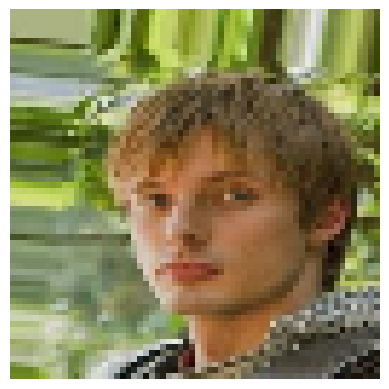

In [4]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

### The discriminator
First, we’ll develop a `discriminator` model that takes as input a candidate image
(real or synthetic) and classifies it into one of two classes: “generated image” or “real
image that comes from the training set.” One of the many issues that commonly
arise with GANs is that the generator gets stuck with generated images that look like
noise. A possible solution is to use dropout in the discriminator, so that’s what we
will do here.

**The GAN discriminator network**

In [5]:
from tensorflow.keras import layers

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        # One dropout layer: an important trick!
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

### The generator

Next, let’s develop a `generator` model that turns a vector (from the latent space—
during training it will be sampled at random) into a candidate image.

**GAN generator network**

In [6]:
# The latent space will be made of 128-dimensional vectors
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # Produce the same number of coefficients we had
        # at the level of the Flatten layer in the encoder.
        layers.Dense(8 * 8 * 128),
        # Revert the Flatten layer of the encoder
        layers.Reshape((8, 8, 128)),
        # Revert the Conv2D layers of the encoder.
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        # The output ends up with shape (28, 28, 1).
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [ ]:
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

### The adversarial network
Finally, we’ll set up the GAN, which chains the generator and the discriminator.
When trained, this model will move the generator in a direction that improves its
ability to fool the discriminator. This model turns latent-space points into a classification
decision—“fake” or “real”—and it’s meant to be trained with labels that are
always “these are real images.” So training gan will update the weights of generator
in a way that makes discriminator more likely to predict “real” when looking at
fake images.
To recapitulate, this is what the training loop looks like schematically. For each
epoch, you do the following:
<ol>
<li>Draw random points in the latent space (random noise).
<li>Generate images with generator using this random noise.
<li>Mix the generated images with real ones.
<li>Train discriminator using these mixed images, with corresponding targets:
either “real” (for the real images) or “fake” (for the generated images).
<li>Draw new random points in the latent space.
<li>Train generator using these random vectors, with targets that all say “these are
real images.” This updates the weights of the generator to move them toward
getting the discriminator to predict “these are real images” for generated
images: this trains the generator to fool the discriminator.
</ol>
Let’s implement it. Like in our VAE example, we’ll use a Model subclass with a custom
train_step(). Note that we’ll use two optimizers (one for the generator and
one for the discriminator), so we will also override compile() to allow for passing
two optimizers.

**The GAN Model**

In [7]:
import tensorflow as tf
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        # Sets up metrics to track the two losses over each training epoch
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    # Sets up metrics to track the two losses over each training epoch
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        # Samples random point in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)
        # Combines them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assembles labels, discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Adds random noise to the labels—an important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Trains the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Samples random points in the latent space
        random_latent_vectors = tf.random.normal(
          shape=(batch_size, self.latent_dim))

        # Assembles labels that say “these are all real images” (it’s a lie!)
        misleading_labels = tf.zeros((batch_size, 1))

        # Trains the generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

Before we start training, let’s also set up a callback to monitor our results: it will use
the generator to create and save a number of fake images at the end of each epoch.

**A callback to sample generated images during training**

In [8]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

**Compiling and training the GAN**

Finally, we can start training. Please note that the following training was done on the dataset of 21,000 images, not the full set of 200,000.

In [ ]:
epochs = 5  # Interesting results will start appearing after epoch 20

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/25
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 528s 81ms/step - d_loss: 0.5656 - g_loss: 1.3633
Epoch 2/25
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 506s 80ms/step - d_loss: 0.6483 - g_loss: 1.0823
Epoch 3/25
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 506s 80ms/step - d_loss: 0.6573 - g_loss: 1.0170
Epoch 4/25
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 506s 80ms/step - d_loss: 0.6297 - g_loss: 1.1385
Epoch 5/25
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 506s 80ms/step - d_loss: 0.5792 - g_loss: 1.3067
Epoch 6/25
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 506s 80ms/step - d_loss: 0.6047 - g_loss: 1.1403
Epoch 7/25
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 506s 80ms/step - d_loss: 0.6397 - g_loss: 1.0234
Epoch 8/25
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 506s 80ms/step - d_loss: 0.6566 - g_loss: 0.9459
Epoch 9/25
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 506s 80ms/step - d_loss: 0.6691 - g_loss: 0.9244
Epoch 10/25
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 506s 80ms/step - d_loss: 0.6647 - g_loss: 0.9285
Epoch 11/25
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 506s 80ms/step - d_loss: 0.6656 - g_loss: 0.92

When training, you may see the adversarial loss begin to increase considerably, while
the discriminative loss tends to zero—the discriminator may end up dominating the
generator. If that’s the case, try reducing the discriminator learning rate, and increase
the dropout rate of the discriminator.
Figure 12.22 shows what our GAN is capable of generating after 30 epochs of training


**Listing 12.38** Compiling and training the GAN.

You’ll start getting
interesting results
after epoch 20.


### Wrapping up

**Figure 12.22** Some generated images around epoch 30


**Figure 12.22b** Some generated images around epoch 99

<ul>
    <li>A GAN consists of a generator network coupled with a discriminator network.
The discriminator is trained to differentiate between the output of the generator
and real images from a training dataset, and the generator is trained to fool the discriminator. Remarkably, the generator never sees images from the training
set directly; the information it has about the data comes from the discriminator.
    <li>GANs are difficult to train, because training a GAN is a dynamic process rather
than a simple gradient descent process with a fixed loss landscape. Getting a
GAN to train correctly requires using a number of heuristic tricks, as well as
extensive tuning.
<li>GANs can potentially produce highly realistic images. But unlike VAEs, the
latent space they learn doesn’t have a neat continuous structure and thus may
not be suited for certain practical applications, such as image editing via latentspace
concept vectors.
</ul>

These few techniques cover only the basics of this fast-expanding field. There’s a lot
more to discover out there—generative deep learning is deserving of an entire book
of its own

## Chapter summary
<ul>
    <li>You can use a sequence-to-sequence model to generate sequence data, one step
at a time. This is applicable to text generation, but also to note-by-note music
generation or any other type of timeseries data.
<li>DeepDream works by maximizing convnet layer activations through gradient
ascent in input space.
<li>In the style-transfer algorithm, a content image and a style image are combined
together via gradient descent to produce an image with the high-level features
of the content image and the local characteristics of the style image.
<li>VAEs and GANs are models that learn a latent space of images and can then
dream up entirely new images by sampling from the latent space. Concept vectors
in the latent space can even be used for image editing.
    </ul>